In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense

from livelossplot import PlotLossesKeras

warnings.filterwarnings('ignore')

# Get the data

In [8]:
cwd = os.getcwd()
up1 = os.path.split(cwd)[0]
data_dir = os.path.join(up1,"data")
data = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith('.csv') if "cv_wells" in x][0]

# Define NN model

In [9]:
def baseline_model(X_train):
    model = Sequential()
    model.add(Dense(28, input_dim=56, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['mse'])
    
    return model

# Setup the data for NN

In [10]:
df = pd.read_csv(data)
scaler = MinMaxScaler() # Scale the data using sklearn minmax scaler

labels = np.array(df['dry'])

features = df.drop(['dry','name'], axis = 1)
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features = np.array(features)

In [11]:
# Train / Test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 10)
    
# NN naming convention
X_train = np.array(train_features)
X_test = np.array(test_features)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

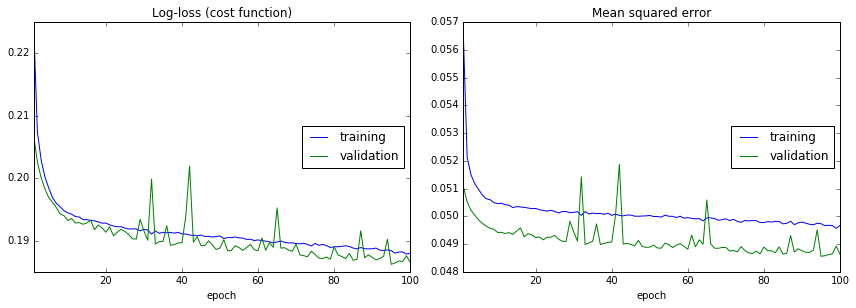

27473/27473 [==============================] - 2s 62us/step - loss: 0.1880 - mean_squared_error: 0.0497 - val_loss: 0.1865 - val_mean_squared_error: 0.0486


In [15]:
# Visualize loss functions
plot_callback = PlotLossesKeras()

# Fit model
model = baseline_model(X_train)
model.fit(X_train, y_train, validation_data=[test_features,test_labels],epochs=100,verbose=1, callbacks = [plot_callback])

In [16]:
predictions = model.predict(X_test)

# Reshape 
predictions = predictions.reshape(predictions.shape[0])

# Take 
preds = []

for i in predictions:
    if i > np.percentile(predictions,95): # >95th percentile of probabilities = 1 (failure), else = 0 (non-failure)
        preds.append(1)
    else:
        preds.append(0)

In [17]:
mape = 100. * (np.abs((preds - y_test) / y_test))
np.mean(mape)

4.444201790784014

In [18]:
accuracy = 100. - np.mean(mape)
accuracy

95.555798209216

# Make a confusion matrix of the predictions 

In [19]:
cm = sklearn.metrics.confusion_matrix(y_test, preds)

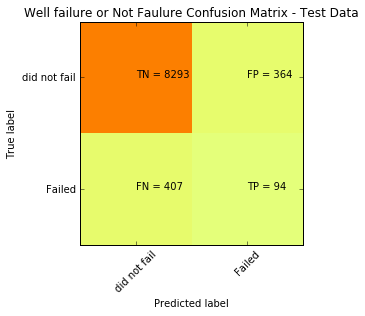

In [20]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['did not fail','Failed']
plt.title('Well failure or Not Faulure Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()